## Libraries and packages

In [10]:
from Bio import Entrez
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
# nltk.download()
email = 'gui-negrini@hotmail.com'

____________________________________________________________________________________

## Functions

In [50]:
def get_PMID_list(search_term):
    '''Returns a list of PMIDs from articles related to the search term'''
    Entrez.email = email
    handle = Entrez.esearch(db="pubmed", term=search_term, retmax=100000)
    record = Entrez.read(handle)
    return list(record["IdList"])

In [51]:
def get_articles_info(PMID_list):
    '''Fetches the articles and scrapes the information needed'''
    list_articles_info = []
    list_error = []

    # I was getting a XML parser error on some IDs, so I had to fetch them one by one instead of passing the whole
    # PMID list as the id parameter of the efetch method. 
    
    for ID in PMID_list:
        Entrez.email = email
        record = 'test'
        try:
            handle = Entrez.efetch(db="pubmed", id=ID, rettype="medline", retmode="xml")
            record = Entrez.read(handle)
            list_articles_info.append(
                {'Id': record['PubmedArticle'][0]['MedlineCitation']['PMID'][:8], 
                'Title': record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleTitle'],
                'Year': record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleDate'][0]['Year'], 
                'Abstract': record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'][0]
                })
        except:
            # Records all IDs that were not fetched
            list_error.append(ID)
            pass
    
    
    list_to_file(list_error, 'listError')
    df_autism_articles = pd.DataFrame(list_articles_info)
    df_autism_articles.to_csv('AutismArticlesRaw.csv', encoding='utf-8', index=False)

In [52]:
def list_to_file(python_list, file_name):
    '''Saves a list to a .txt file at local folder'''
    file = open("{}.txt".format(file_name), "w")
    for element in python_list:
        file.write(element)
        if(element != python_list[-1]): # ensure that it doesn't print a blank line at the end of the file
            file.write("\n")
    file.close()

In [70]:
def file_to_list(file_name):
    '''Reads a .txt file into a list'''
    line_list = []
    file = open("{}.txt".format(file_name), "r")
    for line in file:
        line_list.append(line.rstrip('\n'))
    file.close()
    return line_list

_________________________________________________________________________________________

## Code

#### Getting the PMIDs

In [48]:
# autism_PMID_list = get_PMID_list('autism') # Search and returns a PMID list of articles matching 'autism' search term

In [55]:
print('A total of {} articles were found.'.format(len(autism_PMID_list)))

A total of 44927 articles were found.


In [ ]:
list_to_file(autism_PMID_list, 'autismPMIDList_2') # Saves the PMID list into a local .txt file to avoid repeting the web search

In [54]:
# autism_PMID_list = file_to_list('autismPMIDList_2') # Reads the saved .txt file into a Python list

#### Getting article's information

In [ ]:
# It takes almost 11h to run
get_articles_info(autism_PMID_list)

#### Exploring the data

In [47]:
df_autism_articles = pd.read_csv('AutismArticlesRaw.csv')

In [27]:
df_autism_articles.head()

,Abstract,Id,Title,Year
0,To investigate the risk for psychiatric disord...,30609223,Psychiatric Disorders After Attention-Deficit/...,2019
1,A number of studies have documented the benefi...,30608513,The Influence of Demographic and Child Charact...,2019
2,Identifying genetic diagnoses for neurologic c...,30608006,Genetic Testing Practices of Genetic Counselor...,2019
3,Vitamin or mineral supplementation is consider...,30607900,The Role of Vitamins in Autism Spectrum Disord...,2019
4,GABA<sub>A</sub> receptors are the major inhib...,30607899,The α5-Containing GABA<sub>A</sub> Receptors-a...,2019


In [7]:
df_autism_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21169 entries, 0 to 21168
Data columns (total 4 columns):
Abstract    21148 non-null object
Id          21169 non-null int64
Title       21167 non-null object
Year        21169 non-null int64
dtypes: int64(2), object(2)
memory usage: 661.6+ KB


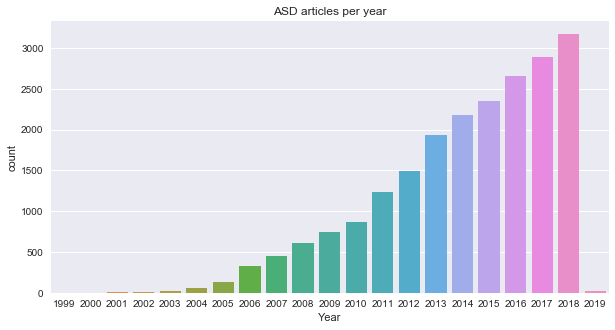

In [59]:
plt.figure(figsize=(10,5))
plt.title('ASD articles per year')
sns.countplot(x='Year', data=df_autism_articles)

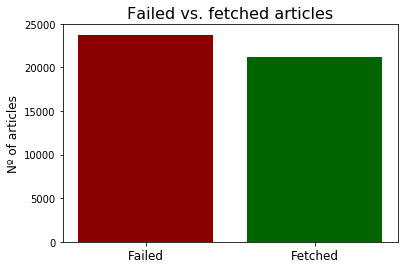

In [75]:
# list_error = file_to_list('listError')
# list_articles_info = df_autism_articles['Abstract']

plt.bar([0,1], [len(list_error), len(list_articles_info)], color=['darkred', 'darkgreen'])
plt.ylabel('Nº of articles', fontsize=12)
plt.xticks([0,1], ['Failed','Fetched'], fontsize=12)
plt.title('Failed vs. fetched articles', fontsize=16)
plt.show()

#### Abstract data preprocessing

In [48]:
# removes all rows/articles with a missing value in any column
df_autism_articles = df_autism_articles.dropna()

# creates a new column in the dataframe for the preprocessed data
preprocessed = pd.Series()
df_autism_articles.insert(loc=1, column='Preprocessed', value=preprocessed)

# replaces with space anything that isn't a lower case or upper case letter
df_autism_articles['Preprocessed'] = df_autism_articles['Abstract'].replace(
    r'[^a-zA-Z]', " ", regex=True)

# replaces multiple spaces with single space
df_autism_articles['Preprocessed'] = df_autism_articles[
    'Preprocessed'].replace(
        r' +', " ", regex=True)

# converts everything to lower case
df_autism_articles['Preprocessed'] = df_autism_articles[
    'Preprocessed'].str.lower()

# removes stop words
stop_words = set(stopwords.words("english"))
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].apply(lambda abstract: 
                                                                              [word for word in str(abstract).split() 
                                                                               if word not in stop_words])

# word stemming
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].apply(lambda abstract: 
                                                                              [stemmer.stem(word) for word in abstract])

# joins the words back into a string
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].str.join(' ')

# saves the dataframe to .csv file
# df_autism_articles.to_csv('PreProcessedAbstracts.csv', encoding='utf-8', index=False)

1. Raw word count: 
23234442
2. Preprocessed word count: 
 14881076


In [51]:
# raw word count
total_word_count = 0
for abstract in df_autism_articles['Abstract']:
    total_word_count = total_word_count + len(abstract)
    
# word count after preprocessing
cleaned_word_count = 0
for abstract in df_autism_articles['Preprocessed']:
    cleaned_word_count = cleaned_word_count + len(abstract)

print('1. Raw word count: \n{}\n2. Preprocessed word count: \n{}'.format(
    total_word_count, cleaned_word_count))

1. Raw word count: 
23234442
2. Preprocessed word count: 
14881076


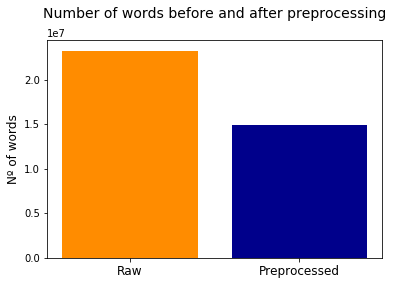

In [67]:
plt.bar([0,1], [total_word_count, cleaned_word_count], color=['darkorange', 'darkblue'])
plt.ylabel('Nº of words', fontsize=12)
plt.xticks([0,1], ['Raw','Preprocessed'], fontsize=12)
plt.title('Number of words before and after preprocessing\n', fontsize=14)
plt.show()

In [76]:
df_autism_articles.head()

,Abstract,Preprocessed,Id,Title,Year
0,To investigate the risk for psychiatric disord...,investig risk psychiatr disord patient newli d...,30609223,Psychiatric Disorders After Attention-Deficit/...,2019
1,A number of studies have documented the benefi...,number studi document benefit neuropsycholog e...,30608513,The Influence of Demographic and Child Charact...,2019
2,Identifying genetic diagnoses for neurologic c...,identifi genet diagnos neurolog condit conside...,30608006,Genetic Testing Practices of Genetic Counselor...,2019
3,Vitamin or mineral supplementation is consider...,vitamin miner supplement consid common use med...,30607900,The Role of Vitamins in Autism Spectrum Disord...,2019
4,GABA<sub>A</sub> receptors are the major inhib...,gaba sub sub receptor major inhibitori neurotr...,30607899,The α5-Containing GABA<sub>A</sub> Receptors-a...,2019
